In [1]:
import sys
if './' not in sys.path:
	sys.path.append('./')
    
from models.util import create_model, load_state_dict
from test_utils import *
import warnings
from src.test.video_codec import *
from src.train.util import *
from pathlib import Path
warnings.filterwarnings("ignore")

/home/maryamsana_98/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/maryamsana_98/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/maryamsana_98/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /data/maryamsana_98/anaconda3/envs/unicontrolwrap/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


/data/maryamsana_98/anaconda3/envs/unicontrolwrap/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `FrechetInceptionDistance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


logging improved.
Enabled sliced_attention.


In [3]:
model = create_model('configs/bi_wrap/uni_v15.yaml').cpu()
ckpt = load_state_dict('experiments/bi_warp_out_finetune/uni_20k.ckpt' , location='cuda')

# filter out any unmatched keys
model_keys = set(model.state_dict())
filtered = {k: v for k, v in ckpt.items() if k in model_keys}
model.load_state_dict(filtered)
model = model.cuda()

No module 'xformers'. Proceeding without it.
UniControlNet: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /data/maryamsana_98/anaconda3/envs/unicontrolwrap/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /data/maryamsana_98/anaconda3/envs/unicontrolwrap/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Loaded model config from [configs/bi_wrap/uni_v15.yaml]
Loaded state_dict from [experiments/bi_warp_out_finetune/uni_20k.ckpt]


In [4]:
from cmp.utils.flowlib import read_flo_file,write_flow

from PIL import Image

fwd_img = 'data/UVG/Beauty/benchmark/decoded_q4/decoded_frame_0000.png'
bwd_img = 'data/UVG/Beauty/benchmark/decoded_q4/decoded_frame_0002.png'


flow  = read_flo_file('data/beauty_recon_flow_fwd.flo')
flow_b = read_flo_file('data/beauty_recon_flow_bwd.flo')

In [8]:
flow = np.transpose(flow, (2, 0,1))
flow_b = np.transpose(flow_b, (2, 0,1))

In [9]:
flow = adaptive_weighted_downsample(flow, target_h=128, target_w=128)
flow_b = adaptive_weighted_downsample(flow_b, target_h=128, target_w=128)
flow_combined = np.concatenate([flow, flow_b])


local_paths = [fwd_img,bwd_img]
local_images = []
for p in local_paths:
    # print(p)
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    local_images.append(img)

prompt =  "A beautiful blonde girl smiling with pink lipstick with black background"
global_image= None
pred = process_wrap(model, 
                    local_images,
                    flow=flow_combined, 
                    prompt=prompt,
                    global_image=global_image,
                    ddim_steps=50)

Global seed set to 42


flow torch.Size([1, 4, 128, 128]) torch.Size([1, 6, 512, 512])
low vram shift started
low vram shift started
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.6884

DDIM Sampler: 100%|██████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.15it/s]


low vram shift started


(-0.5, 1919.5, 1079.5, -0.5)

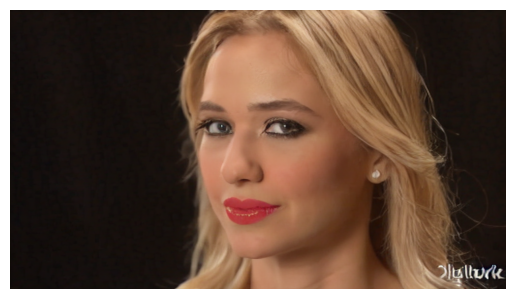

In [16]:
pred_img= cv2.resize(pred[0][0], (1920, 1080), interpolation=cv2.INTER_LANCZOS4)
plt.imshow(pred_img)
plt.axis('off')